# Using CNN for salary prediction based on job description
_Reference: Pre-processing part of this project is partially based on my homework which was based on YSDA NLP github [materials](https://github.com/yandexdataschool/nlp_course/blob/master/week02_classification/seminar.ipynb)_



In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.23.5 scipy==1.10.1 gensim==4.3.2 transformers==4.37.0
!pip install --force-reinstall scipy gensim transformers

Found existing installation: numpy 1.23.5
Uninstalling numpy-1.23.5:
  Successfully uninstalled numpy-1.23.5
  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires scipy>=1.11.1, but you have scipy 1.10.1 which is incompatible.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.37.0 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
bigframes 2.1.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.2

  Using cached scipy-1.15.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached transformers-4.51.3-py3-none-any.whl.metadata (38 kB)
  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached huggingface_hub-0.31.1-py3-none-any.whl.metadata (13 kB)
  Using cached packaging-25.0-py3-none-any.whl.metadata (3.3 kB)
  Using cached PyYAML-6.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction import DictVectorizer
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

## Goal
We'll work with dataset from Kaggle Job Salsry prediction competition trying to use different Types of Neural Networks for Salary prediction. Including CNN, RNN, multi-headed models and pretrained models

In [2]:
!curl -L "https://www.dropbox.com/s/5msc5ix7ndyba10/Train_rev1.csv.tar.gz?dl=1" -o Train_rev1.csv.tar.gz
!tar xzf Train_rev1.csv.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   138  100   138    0     0    188      0 --:--:-- --:--:-- --:--:--   188
100    17  100    17    0     0     13      0  0:00:01  0:00:01 --:--:--     0
100   475    0   475    0     0    235      0 --:--:--  0:00:02 --:--:--   235
100  119M  100  119M    0     0  29.2M      0  0:00:04  0:00:04 --:--:-- 85.0M


In [3]:
!ls

sample_data  Train_rev1.csv  Train_rev1.csv.tar.gz


In [4]:
import pandas as pd

data = pd.read_csv("Train_rev1.csv", index_col=None)


##Feature Engeneering

First, let's summarize our target variable in order to somehow cope with the fact that there are a lot of outliers among salaries - extremely high values.

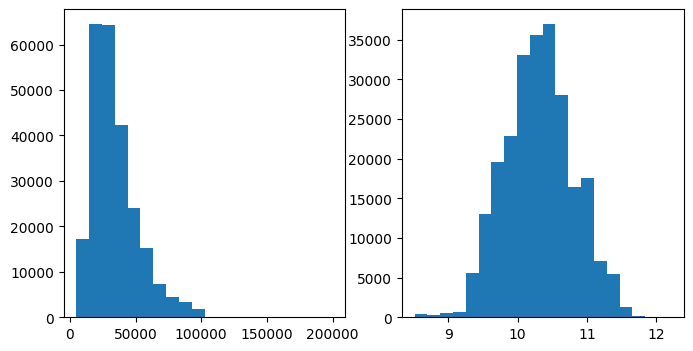

In [5]:
data["Log1pSalary"] = np.log1p(data["SalaryNormalized"]).astype("float32")

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)

plt.subplot(1, 2, 2)
plt.hist(data["Log1pSalary"], bins=20)

plt.show()

to predict __Log1pSalary__ we have following set of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [6]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna("NaN")
data[text_columns] = data[text_columns].fillna("NaN")


Let's start with tokenizing Title and Full Description features



In [7]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [8]:
from nltk.tokenize import WordPunctTokenizer


tokenizer = WordPunctTokenizer()

def normalize(text):  # noqa: E302
    tokens = tokenizer.tokenize(str(text).lower())
    return " ".join(tokens)


data[text_columns] = data[text_columns].applymap(normalize)

/tmp/ipython-input-3271027076.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data[text_columns] = data[text_columns].applymap(normalize)


In [9]:
data[text_columns].iloc[0, 0]

'engineering systems analyst'

In [10]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == "mathematical modeller / simulation analyst / opera"
assert data["Title"][54321] == "international digital account manager ( german )"

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [11]:
from collections import Counter

token_counts = Counter()
for text in data[text_columns].values.flatten():
    token_counts.update(text.split(" "))

In [12]:
print("Total unique tokens :", len(token_counts))
print("\n".join(map(str, token_counts.most_common(n=5))))
print("...")
print("\n".join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print("Correct!")

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Let's see how many words are there for each count.

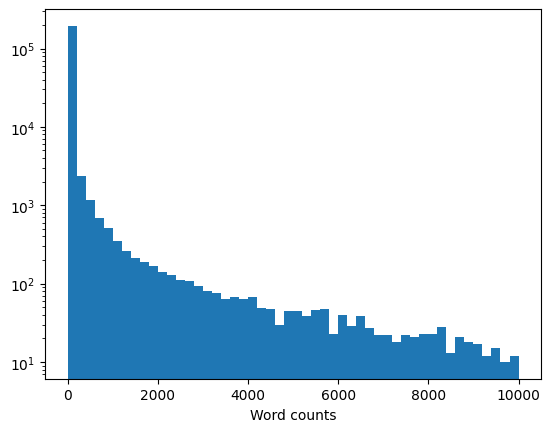

In [13]:
plt.hist(list(token_counts.values()), range=[0, 10 ** 4], bins=50, log=True)
plt.xlabel("Word counts")
plt.show()

Now we will filter tokens a list of all tokens that occur at least 10 times.

In [14]:
min_count = 10

tokens = [token for token, count in token_counts.items() if count >= min_count]

In [15]:
# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert "me" in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


In [16]:
len(set(tokens))

34158

Build an inverse token index: a dictionary from token to it's index in `tokens`.

In [17]:
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

In [18]:
len(token_to_idx)

34158

In [19]:
len(tokens)

34158

And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [20]:
UNK_IDX = token_to_idx[UNK]
PAD_IDX = token_to_idx[PAD]


def as_matrix(sequences, max_len=None):
    """Convert a list of tokens into a matrix with padding"""
    if isinstance(sequences[0], str):
        sequences = [seq.split(" ") for seq in sequences]

    sequences_max_len = max(len(seq) for seq in sequences)
    if max_len is None:
        max_len = sequences_max_len
    else:
        max_len = min(sequences_max_len, max_len)

    matrix = np.full((len(sequences), max_len), PAD_IDX)
    for i, seq in enumerate(sequences):
        for j, token in enumerate(seq):
            if j >= max_len:
                break

            matrix[i, j] = token_to_idx.get(token, UNK_IDX)

    return matrix

In [21]:
data["Title"].nunique()

129653

In [22]:
print("Lines:")
print("\n".join(data["Title"][::100000//2].values), end="\n\n")
print("Matrix:")
print(as_matrix(data["Title"][::100000//2]))

Lines:
engineering systems analyst
smart metering project manager ( complex network , infrastructure , compl
hr assistant
programmes director global defence organisation
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1     1     1     1     1     1     1]
 [28447 19617 24359 18864    33  6988 20887   158 15824   158     0]
 [15020  2844     1     1     1     1     1     1     1     1     1]
 [24342  9324 13488  8713 22068     1     1     1     1     1     1]
 [27645 10201    16 15215 10804     1     1     1     1     1     1]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [23]:
from sklearn.feature_extraction import DictVectorizer


# We only consider top-1k most frequent companies to minimize memory usage
company_counts = Counter(data["Company"])
top_companies = set(name for name, count in company_counts.most_common(1000))
data["Company"] = data["Company"].apply(
    lambda company: company if company in top_companies else "Other"
)

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1));

In [24]:
data[categorical_columns]

,Category,Company,LocationNormalized,ContractType,ContractTime
0,Engineering Jobs,Gregory Martin International,Dorking,NaN,permanent
1,Engineering Jobs,Gregory Martin International,Glasgow,NaN,permanent
2,Engineering Jobs,Gregory Martin International,Hampshire,NaN,permanent
3,Engineering Jobs,Gregory Martin International,Surrey,NaN,permanent
4,Engineering Jobs,Gregory Martin International,Surrey,NaN,permanent
...,...,...,...,...,...
244763,Teaching Jobs,NaN,Swindon,NaN,contract
244764,Teaching Jobs,NaN,Swindon,NaN,contract
244765,Teaching Jobs,NaN,Swindon,NaN,contract
244766,Teaching Jobs,NaN,Wiltshire,NaN,contract


In [25]:
data[categorical_columns].apply(dict, axis=1)

,0
0,"{'Category': 'Engineering Jobs', 'Company': 'G..."
1,"{'Category': 'Engineering Jobs', 'Company': 'G..."
2,"{'Category': 'Engineering Jobs', 'Company': 'G..."
3,"{'Category': 'Engineering Jobs', 'Company': 'G..."
4,"{'Category': 'Engineering Jobs', 'Company': 'G..."
...,...
244763,"{'Category': 'Teaching Jobs', 'Company': 'NaN'..."
244764,"{'Category': 'Teaching Jobs', 'Company': 'NaN'..."
244765,"{'Category': 'Teaching Jobs', 'Company': 'NaN'..."
244766,"{'Category': 'Teaching Jobs', 'Company': 'NaN'..."


In [26]:
dict(data[categorical_columns].loc[0, :])

{'Category': 'Engineering Jobs',
 'Company': 'Gregory Martin International',
 'LocationNormalized': 'Dorking',
 'ContractType': 'NaN',
 'ContractTime': 'permanent'}

In [27]:
data[categorical_columns].apply(dict, axis=1)[0]

{'Category': 'Engineering Jobs',
 'Company': 'Gregory Martin International',
 'LocationNormalized': 'Dorking',
 'ContractType': 'NaN',
 'ContractTime': 'permanent'}

In [28]:
categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1)).shape

(244768, 3768)

In [29]:
data[categorical_columns]

,Category,Company,LocationNormalized,ContractType,ContractTime
0,Engineering Jobs,Gregory Martin International,Dorking,NaN,permanent
1,Engineering Jobs,Gregory Martin International,Glasgow,NaN,permanent
2,Engineering Jobs,Gregory Martin International,Hampshire,NaN,permanent
3,Engineering Jobs,Gregory Martin International,Surrey,NaN,permanent
4,Engineering Jobs,Gregory Martin International,Surrey,NaN,permanent
...,...,...,...,...,...
244763,Teaching Jobs,NaN,Swindon,NaN,contract
244764,Teaching Jobs,NaN,Swindon,NaN,contract
244765,Teaching Jobs,NaN,Swindon,NaN,contract
244766,Teaching Jobs,NaN,Wiltshire,NaN,contract


In [30]:
data[categorical_columns].apply(dict, axis=1)

,0
0,"{'Category': 'Engineering Jobs', 'Company': 'G..."
1,"{'Category': 'Engineering Jobs', 'Company': 'G..."
2,"{'Category': 'Engineering Jobs', 'Company': 'G..."
3,"{'Category': 'Engineering Jobs', 'Company': 'G..."
4,"{'Category': 'Engineering Jobs', 'Company': 'G..."
...,...
244763,"{'Category': 'Teaching Jobs', 'Company': 'NaN'..."
244764,"{'Category': 'Teaching Jobs', 'Company': 'NaN'..."
244765,"{'Category': 'Teaching Jobs', 'Company': 'NaN'..."
244766,"{'Category': 'Teaching Jobs', 'Company': 'NaN'..."


In [31]:
len(categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))[0])

3768

In [32]:
data[categorical_columns].nunique()

,0
Category,29
Company,1001
LocationNormalized,2732
ContractType,3
ContractTime,3


In [33]:
29 + 1001 + 2732 + 3 + 3

3768

In [34]:
data['Title']

,Title
0,engineering systems analyst
1,stress engineer glasgow
2,modelling and simulation analyst
3,engineering systems analyst / mathematical mod...
4,"pioneer , miser engineering systems analyst"
...,...
244763,teacher of science
244764,teacher of business studies and ict
244765,english teacher
244766,supply teachers


In [35]:
data['FullDescription']

,FullDescription
0,engineering systems analyst dorking surrey sal...
1,stress engineer glasgow salary **** to **** we...
2,mathematical modeller / simulation analyst / o...
3,engineering systems analyst / mathematical mod...
4,"pioneer , miser engineering systems analyst do..."
...,...
244763,position : qualified teacher subject / special...
244764,position : qualified teacher or nqt subject / ...
244765,position : qualified teacher subject / special...
244766,position : qualified teacher subject / special...


In [36]:
data[categorical_columns]

,Category,Company,LocationNormalized,ContractType,ContractTime
0,Engineering Jobs,Gregory Martin International,Dorking,NaN,permanent
1,Engineering Jobs,Gregory Martin International,Glasgow,NaN,permanent
2,Engineering Jobs,Gregory Martin International,Hampshire,NaN,permanent
3,Engineering Jobs,Gregory Martin International,Surrey,NaN,permanent
4,Engineering Jobs,Gregory Martin International,Surrey,NaN,permanent
...,...,...,...,...,...
244763,Teaching Jobs,NaN,Swindon,NaN,contract
244764,Teaching Jobs,NaN,Swindon,NaN,contract
244765,Teaching Jobs,NaN,Swindon,NaN,contract
244766,Teaching Jobs,NaN,Wiltshire,NaN,contract


##Training pipeline


In [37]:
from sklearn.model_selection import train_test_split


data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [38]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a neural-network-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IDX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch["Categorical"] = categorical_vectorizer.transform(
        data[categorical_columns].apply(dict, axis=1)
    )

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1.0 - word_dropout)

    if target_column in data.columns:
        batch[target_column] = data[target_column].values

    return batch


def apply_word_dropout(matrix, keep_prob, replace_with=UNK_IDX):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prob, 1 - keep_prob])
    dropout_mask &= matrix != PAD_IDX
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [39]:
example_batch = make_batch(data_train[:5], max_len=15)
# print("Example batch:")
# print(example_batch)
# print("FullDescription shape:", example_batch["FullDescription"].shape)

In [40]:
data_train[:5]

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
0,69173058,senior support worker,senior support worker wanted a senior support ...,"Taunton, Somerset Somerset South West",Taunton,NaN,permanent,Other,Healthcare & Nursing Jobs,15931 - 17082 per annum,16506,totaljobs.com,9.711540
1,72450873,statistical / mathematical modeller in pharmac...,statistical / mathematical modeller in pharmac...,North West,North West London,NaN,permanent,Other,Scientific & QA Jobs,"From 30,000 to 40,000 per annum 30-40K",35000,totaljobs.com,10.463132
2,68364211,emc team leader ( def stan ),the opportunity my client is currently seeking...,Surrey,Surrey,NaN,permanent,Other,Engineering Jobs,45k + Bonus + Pension,45000,justengineers.net,10.714440
3,69556873,"core java engineer london , big data","core java engineer london , big data , mysql ,...",UK London,London,NaN,permanent,Engage PSG,IT Jobs,"55000 - 70000 per annum + Bens, Bonus (up to 2...",62500,careers4a.com,11.042938
4,71304393,driver,"**** driver reqd for busy parcel round , exper...",Brentwood,Brentwood,full_time,NaN,Other,Logistics & Warehouse Jobs,350.00 - 400.00 per week,18000,Jobcentre Plus,9.798182


In [41]:
example_batch

{'Title': array([[27645, 29893, 33674,     1,     1,     1,     1],
        [29239,   197, 19175, 20042, 15554, 23162,  4051],
        [10609, 30412, 17746,    33,  8705, 29157,    65],
        [ 7574, 16690, 10804, 18371,   158,  3958,  8418],
        [ 9895,     1,     1,     1,     1,     1,     1]]),
 'FullDescription': array([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451,
         32939, 12587,   982, 26081, 27746, 15554],
        [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,
            82,  3547,  6061, 11400, 25843,  2189],
        [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412,
         17746, 10481,  6927, 19815, 30695, 31100],
        [ 7574, 16690, 10804, 18371,   158,  3958,  8418,   158, 20610,
           158, 21307,   158, 20529,   158,  9519],
        [   82,  9895, 25998, 12587,  5025, 22551, 26734,   158, 11558,
         23947,  5026, 21308, 11171, 19884, 23548]]),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],

In [42]:
print(example_batch['Title'].shape, example_batch['Title'], sep='\n')

(5, 7)
[[27645 29893 33674     1     1     1     1]
 [29239   197 19175 20042 15554 23162  4051]
 [10609 30412 17746    33  8705 29157    65]
 [ 7574 16690 10804 18371   158  3958  8418]
 [ 9895     1     1     1     1     1     1]]


In [43]:
print(example_batch['FullDescription'].shape, example_batch['FullDescription'], sep='\n')

(5, 15)
[[27645 29893 33674 32939   982 27645 29893 33674 16451 32939 12587   982
  26081 27746 15554]
 [29239   197 19175 20042 15554 23162  4051 25511   907    82  3547  6061
  11400 25843  2189]
 [30746 21956 20601  6409 16451  8165 27493   982 30412 17746 10481  6927
  19815 30695 31100]
 [ 7574 16690 10804 18371   158  3958  8418   158 20610   158 21307   158
  20529   158  9519]
 [   82  9895 25998 12587  5025 22551 26734   158 11558 23947  5026 21308
  11171 19884 23548]]


In [44]:
print(example_batch['Categorical'].shape, example_batch['Categorical'], sep='\n')

(5, 3768)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [45]:
print(example_batch['Log1pSalary'].shape, example_batch['Log1pSalary'], sep='\n')

(5,)
[ 9.71154   10.463132  10.71444   11.042938   9.7981825]


In [46]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """iterates minibatches of data in random order"""
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target

        if not cycle:
            break

To generate minibatches we will use simple pyton generator.

In [47]:
iterator = iterate_minibatches(data_train, 3)
batch, target = next(iterator)

In [48]:
batch

{'Title': array([[ 8977, 18864, 34100, 19964, 32267,  9083, 34100, 21282, 18371],
        [27645, 20679,  1193, 18864,     1,     1,     1,     1,     1],
        [ 6444, 17744, 21436,     1,     1,     1,     1,     1,     1]]),
 'FullDescription': array([[ 8977, 18864, 34100, 19964, 32267,  9083, 34100, 21282, 18371,
           169, 22209,  6409, 16451,   982, 17753, 18761,  7412, 31997,
         31363,  2189,  8977,  4875,   158, 20918,  4875,  2189, 25599,
         27262,  1315, 18371, 33554, 32391, 31100,    82, 18640,   169,
         22209,  6409, 16451, 21358, 27493,  2142, 11563, 27645,  8977,
         18864, 31100, 14326, 32170, 30746,  8977,  4875, 12998, 21788,
           982,   768, 20918,  4875, 26081, 27259, 15554, 21282, 33260,
         18371,   169, 30746, 24359, 33435,  7038,   982, 21421, 21634,
         25135, 12778, 31274, 21634,  2357, 33554, 14599, 12254,   169,
         22209,  6409, 16451, 27493,  2142, 11563,  8977, 18864,  5315,
         21634, 17753,   982, 3

In [88]:
# batch, target = next(iterator)
# batch

## Architecture

Our main model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

This clearly doesn't fit into PyTorch __Sequential__ interface. To build such a network, one will have to use [__PyTorch nn.Module API__](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

But to start with let's build the simple model using only the part of the data. Let's create the baseline solution using only the description part (so it should definetely fit into the Sequential model).

In [49]:
import torch.nn as nn

# Initially, our FullDescription has a shape [batch_size, seq_len].
# After an Embedding layer shape will be [batch_size, seq_len, embedding_size].
# However, Conv1d layer expects batches of shape [batch_size, embedding_size, seq_len].
# We will use this layer to fix this misunderstanding.
class Reorder(nn.Module):
    def forward(self, input):
        return input.permute((0, 2, 1))

In [50]:
simple_model = nn.Sequential(
    nn.Embedding(len(tokens), 64),
    Reorder(),
    nn.Conv1d(64, 128, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.AdaptiveMaxPool1d(1), #,
    nn.Flatten(),
    nn.Linear(128, 1)
)

In [51]:
torch.tensor(batch["Title"][:2, :10])

tensor([[ 8977, 18864, 34100, 19964, 32267,  9083, 34100, 21282, 18371],
        [27645, 20679,  1193, 18864,     1,     1,     1,     1,     1]])

In [52]:
torch.tensor(batch["FullDescription"][:2, :10])

tensor([[ 8977, 18864, 34100, 19964, 32267,  9083, 34100, 21282, 18371,   169],
        [30746, 27645, 20679,  1193, 18864, 33435, 30225, 26155, 12587,   982]])

In [53]:
x1 = nn.Embedding(len(tokens), 64)(torch.tensor(batch["Title"][:2, :10]))
x2 = Reorder()(x1)
x3 = nn.Conv1d(64, 128, kernel_size=3)(x2)
x4 = nn.AdaptiveMaxPool1d(2)(x3)
x5 = nn.Flatten()(x4)

In [54]:
torch.tensor(batch["FullDescription"][:2, :10]).shape

torch.Size([2, 10])

In [55]:
x1.shape

torch.Size([2, 9, 64])

In [56]:
x2.shape

torch.Size([2, 64, 9])

In [57]:
x3.shape

torch.Size([2, 128, 7])

In [58]:
x4.shape

torch.Size([2, 128, 2])

In [59]:
x5.shape

torch.Size([2, 256])

In [60]:
list(simple_model.named_parameters())[0][-1].shape

torch.Size([34158, 64])

In [61]:
batch["FullDescription"][:1, :10]

array([[ 8977, 18864, 34100, 19964, 32267,  9083, 34100, 21282, 18371,
          169]])

In [62]:
import torch

# Check your model. `torch.long` tensors are required for nn.Embedding layers.
simple_model(torch.tensor(batch["FullDescription"][:1, :10], dtype=torch.long)) #если тоже самое будет падать на Title, то присмотреться к размерам ядер и т.д.

tensor([[-0.3186]], grad_fn=<AddmmBackward0>)

In [63]:
torch.tensor(batch["Title"], dtype=torch.long).shape

torch.Size([3, 9])

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
simple_model.to(device);

To evaluate the model we can switch it to `eval` state. Let's check the model quality.

In [65]:
@torch.no_grad()
def evaluate_model(model, data, batch_size=256, name=None, **kwargs):
    squared_error = abs_error = num_samples = 0.0
    data_iterator = iterate_minibatches(data, batch_size, shuffle=False, **kwargs)
    for batch, target in data_iterator:
        batch = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        pred = model(batch)[:, 0].cpu().numpy()

        squared_error += np.sum(np.square(pred - target))
        abs_error += np.sum(np.abs(pred - target))
        num_samples += len(target)

    if name is not None:
        print(f"{name}:")

    print(f"MSE: {squared_error / num_samples:.5f}")
    print(f"MAE: {abs_error / num_samples:.5f}")


# evaluate_model(simple_model, data_train, name="Train")
# evaluate_model(simple_model, data_val, name="Val")

In [66]:
first_model = nn.Sequential(
    nn.Embedding(len(tokens), 64),
    Reorder(),
    nn.Conv1d(64, 256, kernel_size=3),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.AdaptiveMaxPool1d(1), #,
    nn.Flatten(),
    nn.Linear(256, 128),
    nn.Linear(128, 1),
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
first_model.to(device);

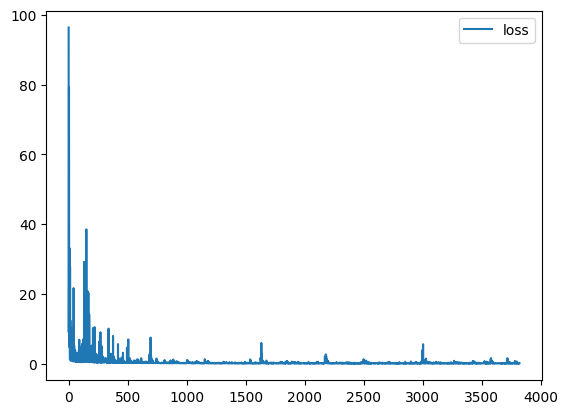

In [67]:
from IPython.display import clear_output


epochs = 5
model = first_model
opt = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

history = []
for epoch in range(epochs):
    for batch, target in iterate_minibatches(data_train):
        # Preprocessing the batch data and target
        batch = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        target = torch.tensor(target, device=device)

        predictions = model(batch)
        predictions = predictions.flatten()

        # YOUR CODE HERE
        # Compute loss.
        loss = criterion(predictions, target)

        # YOUR CODE HERE
        # Train with backprop.
        opt.zero_grad()
        loss.backward()
        opt.step()

        history.append(loss.item())
        if len(history) % 10 == 0:
            clear_output(wait=True)
            plt.plot(history, label="loss")
            plt.legend()
            plt.show()

In [68]:

evaluate_model(first_model, data_train, name="Train")
evaluate_model(first_model, data_val, name="Val")

Train:
MSE: 0.62665
MAE: 0.72567
Val:
MSE: 0.59168
MAE: 0.69227


### Now let's Try to Inplement 3-headed Network.



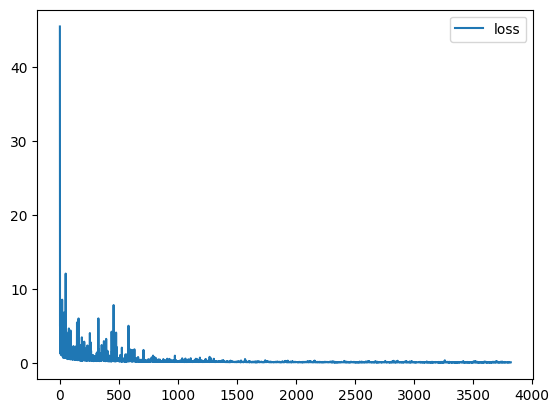

In [69]:
from IPython.display import clear_output

class TextHead(nn.Module):
    def __init__(self, vocab_size, emb_dim=64, out_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.conv = nn.Conv1d(emb_dim, out_dim, kernel_size=3)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(out_dim)
        self.pool = nn.AdaptiveMaxPool1d(1)

    def forward(self, x):

        if x.dim() == 2:
            x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = self.relu(x)
        x = self.bn(x)
        x = self.pool(x)
        return x.squeeze(-1)

#  3-headed model
class ThreeHeadedModel(nn.Module):
    def __init__(self,vocab_size_desc = 34158, vocab_size_title=129653, num_categories=3768, hid_dim=128):
        super().__init__()
        #Description Head
        self.desc_head = TextHead(vocab_size_desc, emb_dim=64, out_dim=hid_dim)
        #Title Head
        self.title_head = TextHead(vocab_size_title, emb_dim=64, out_dim=hid_dim)
        #categorical Head
        self.category_head = nn.Sequential(
            nn.Linear(num_categories, hid_dim),
            nn.ReLU()
        )
        #Final Layer
        self.out = nn.Linear(hid_dim * 3, 1)

    def forward(self, x_desc, x_title, x_category):
        desc_out = self.desc_head(x_desc)
        title_out = self.title_head(x_title)
        category_out = self.category_head(x_category)
        combined = torch.cat([desc_out, title_out, category_out], dim=1)
        return self.out(combined).flatten()




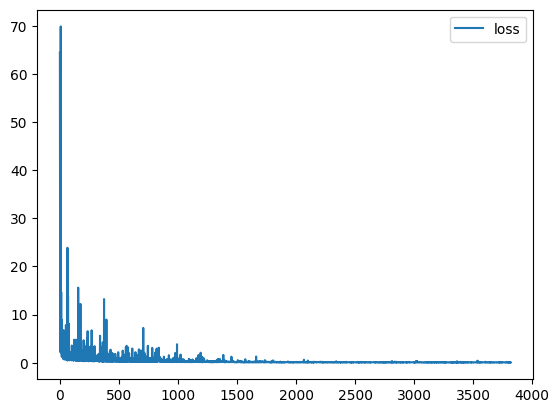

In [85]:
vocab_size_desc = 34158
vocab_size_title = 129653
num_categories = 3768

model_3h = ThreeHeadedModel(vocab_size_desc, vocab_size_title, num_categories).to(device)
opt = torch.optim.Adam(model_3h.parameters())
criterion = nn.MSELoss()


history = []
epochs = 5

for epoch in range(epochs):
    for batch, target in iterate_minibatches(data_train):

        x_desc = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        x_title = torch.tensor(batch["Title"], dtype=torch.long, device=device)
        x_category = torch.tensor(batch["Categorical"], dtype=torch.float, device=device)
        target = torch.tensor(target, device=device)


        predictions = model_3h(x_desc, x_title, x_category)
        loss = criterion(predictions, target)


        opt.zero_grad()
        loss.backward()
        opt.step()

        history.append(loss.item())
        if len(history) % 10 == 0:
            clear_output(wait=True)
            plt.plot(history, label="loss")
            plt.legend()
            plt.show()

In [86]:
@torch.no_grad()
def evaluate_model_3headed(model, data, batch_size=256, name=None, device=device):
    model.eval()
    squared_error = abs_error = num_samples = 0.0

    for batch, target in iterate_minibatches(data, batch_size, shuffle=False):
        # Подготовка данных для всех трёх голов
        x_desc = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        x_title = torch.tensor(batch["Title"], dtype=torch.long, device=device)
        x_category = torch.tensor(batch["Categorical"], dtype=torch.float, device=device)
        target = torch.tensor(target, dtype=torch.float, device=device)


        pred = model(x_desc, x_title, x_category).cpu().numpy()


        squared_error += np.sum(np.square(pred - target.cpu().numpy()))
        abs_error += np.sum(np.abs(pred - target.cpu().numpy()))
        num_samples += len(target)


    print(f"Results for {name}:")
    print(f"MSE: {squared_error / num_samples:.5f}")
    print(f"MAE: {abs_error / num_samples:.5f}")

In [87]:
evaluate_model_3headed(model_3h, data_val, name="Val")

Results for Val:
MSE: 0.08605
MAE: 0.22295


We have achieved significant improvements in metrics compared to the model without a multi-head structure.

###Now let's compare RNN to CNN (x1.75 bonus)
We'll try to use LSTM in our 3-headed model


In [88]:
class LSTMThreeHeadedModel(nn.Module):
    def __init__(self, vocab_size_desc=34158, vocab_size_title=129653, num_categories=3768, hid_dim=128, lstm_layers=1):
        super().__init__()

        self.emb_dim = 64


        self.desc_embed = nn.Embedding(vocab_size_desc, self.emb_dim)
        self.desc_lstm = nn.LSTM(self.emb_dim, hid_dim, lstm_layers, batch_first=True)


        self.title_embed = nn.Embedding(vocab_size_title, self.emb_dim)
        self.title_lstm = nn.LSTM(self.emb_dim, hid_dim, lstm_layers, batch_first=True)


        self.category_head = nn.Sequential(
            nn.Linear(num_categories, hid_dim),
            nn.ReLU()
        )


        self.out = nn.Linear(hid_dim * 3, 1)

    def forward(self, x_desc, x_title, x_category):

        desc_emb = self.desc_embed(x_desc)
        desc_out, _ = self.desc_lstm(desc_emb)
        desc_out = desc_out[:, -1, :]


        title_emb = self.title_embed(x_title)
        title_out, _ = self.title_lstm(title_emb)
        title_out = title_out[:, -1, :]


        category_out = self.category_head(x_category)


        combined = torch.cat([desc_out, title_out, category_out], dim=1)
        return self.out(combined).flatten()

In [89]:
!pip install torchinfo
import torchinfo
from torchinfo import summary

In [91]:
model_stats = summary(
    model_lstm,
    input_data=[x_desc, x_title, x_category],  # примеры входных данных
    verbose=2,  # подробный вывод
    col_names=["input_size", "output_size", "num_params", "mult_adds"],
    depth=3  # глубина детализации
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds
LSTMThreeHeadedModel                     [256, 1693]               [256]                     --                        --
├─Embedding: 1-1                         [256, 1693]               [256, 1693, 643]          21,963,594                5,622,680,064
│    └─weight                                                                                └─21,963,594
├─LSTM: 1-2                              [256, 1693, 643]          [256, 1693, 128]          395,776                   171,532,484,608
│    └─weight_ih_l0                                                                          ├─329,216
│    └─weight_hh_l0                                                                          ├─65,536
│    └─bias_ih_l0                                                                            ├─512
│    └─bias_hh_l0                                                      

In [92]:
torch.cuda.empty_cache()  # очистить кеш CUDA перед запуском

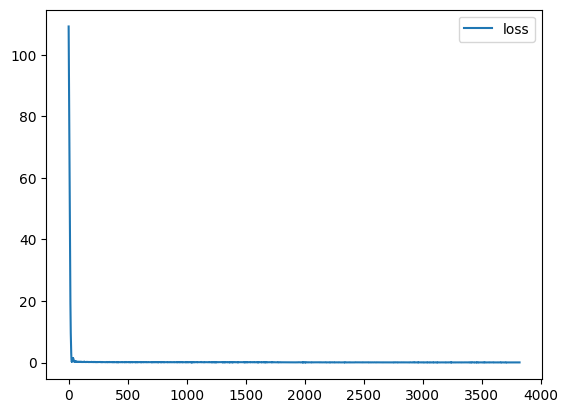

In [93]:
vocab_size_desc = 34158
vocab_size_title = 129653
num_categories = 3768

model_lstm = LSTMThreeHeadedModel(vocab_size_desc, vocab_size_title, num_categories).to(device)
opt = torch.optim.Adam(model_lstm.parameters())
criterion = nn.MSELoss()


history = []
epochs = 5

for epoch in range(epochs):
    for batch, target in iterate_minibatches(data_train):

        x_desc = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        x_title = torch.tensor(batch["Title"], dtype=torch.long, device=device)
        x_category = torch.tensor(batch["Categorical"], dtype=torch.float, device=device)
        target = torch.tensor(target, device=device)


        predictions = model_lstm(x_desc, x_title, x_category)
        loss = criterion(predictions, target)


        opt.zero_grad()
        loss.backward()
        opt.step()

        history.append(loss.item())
        if len(history) % 10 == 0:
            clear_output(wait=True)
            plt.plot(history, label="loss")
            plt.legend()
            plt.show()

In [94]:
evaluate_model_3headed(model_lstm, data_val, name="Val")

Results for Val:
MSE: 0.07517
MAE: 0.20148


This model has about the same number of parameters as the previous one:

In [97]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Module", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, f"{params:,}"])
        total_params += params
    print(table)
    print(f"Total trainable parameters: {total_params:,}")
    return total_params

In [98]:
model_2 = ThreeHeadedModel(vocab_size_desc, vocab_size_title, num_categories)
count_parameters(model_2)
model_3 = LSTMThreeHeadedModel(vocab_size_desc, vocab_size_title, num_categories)
count_parameters(model_3)

+-----------------------------+------------+
|            Module           | Parameters |
+-----------------------------+------------+
|  desc_head.embedding.weight | 2,186,112  |
|    desc_head.conv.weight    |   24,576   |
|     desc_head.conv.bias     |    128     |
|     desc_head.bn.weight     |    128     |
|      desc_head.bn.bias      |    128     |
| title_head.embedding.weight | 8,297,792  |
|    title_head.conv.weight   |   24,576   |
|     title_head.conv.bias    |    128     |
|     title_head.bn.weight    |    128     |
|      title_head.bn.bias     |    128     |
|    category_head.0.weight   |  482,304   |
|     category_head.0.bias    |    128     |
|          out.weight         |    384     |
|           out.bias          |     1      |
+-----------------------------+------------+
Total trainable parameters: 11,016,641
+-------------------------+------------+
|          Module         | Parameters |
+-------------------------+------------+
|    desc_embed.weight    | 

11165377

### Let's try Word2Vec instead of nn.Embeddings


In [99]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 85.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 110.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 15.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatib

In [99]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from gensim.models import KeyedVectors
from gensim.downloader import load
w2v_model = load('word2vec-google-news-300')

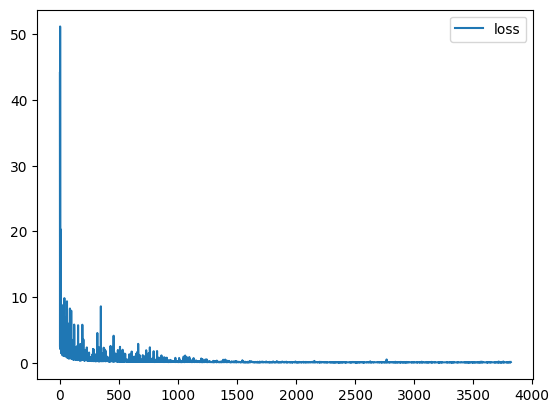

In [100]:

class TextHeadW2V(nn.Module):
    def __init__(self, w2v_model, out_dim=128, freeze_embeddings=True):
        super().__init__()

        vocab_size = len(w2v_model.key_to_index)
        emb_dim = w2v_model.vector_size


        weights = torch.FloatTensor(w2v_model.vectors)
        self.embedding = nn.Embedding.from_pretrained(weights, freeze=freeze_embeddings)

        self.conv = nn.Conv1d(emb_dim, out_dim, kernel_size=3)
        self.relu = nn.ReLU()
        self.bn = nn.BatchNorm1d(out_dim)
        self.pool = nn.AdaptiveMaxPool1d(1)

    def forward(self, x):

        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.conv(x)
        x = self.relu(x)
        x = self.bn(x)
        x = self.pool(x)
        return x.squeeze(-1)
# using same structure
class ThreeHeadedModelW2V(nn.Module):
    def __init__(self, w2v_model, num_categories=3768, hid_dim=128):
        super().__init__()
        #
        self.desc_head = TextHeadW2V(w2v_model, out_dim=hid_dim)
        self.title_head = TextHeadW2V(w2v_model, out_dim=hid_dim)


        self.category_head = nn.Sequential(
            nn.Linear(num_categories, hid_dim),
            nn.ReLU()
        )


        self.out = nn.Linear(hid_dim * 3, 1)

    def forward(self, x_desc, x_title, x_category):
        desc_out = self.desc_head(x_desc)
        title_out = self.title_head(x_title)
        category_out = self.category_head(x_category)
        combined = torch.cat([desc_out, title_out, category_out], dim=1)
        return self.out(combined).flatten()

model_w2v = ThreeHeadedModelW2V(w2v_model, num_categories).to(device)
opt = torch.optim.Adam(model_w2v.parameters())
criterion = nn.MSELoss()

history = []
epochs = 5

for epoch in range(epochs):
    for batch, target in iterate_minibatches(data_train):

        x_desc = torch.tensor(batch["FullDescription"], dtype=torch.long, device=device)
        x_title = torch.tensor(batch["Title"], dtype=torch.long, device=device)
        x_category = torch.tensor(batch["Categorical"], dtype=torch.float, device=device)
        target = torch.tensor(target, device=device)

        predictions = model_w2v(x_desc, x_title, x_category)
        loss = criterion(predictions, target)

        opt.zero_grad()
        loss.backward()
        opt.step()

        history.append(loss.item())
        if len(history) % 10 == 0:
            clear_output(wait=True)
            plt.plot(history, label="loss")
            plt.legend()
            plt.show()

In [101]:
evaluate_model_3headed(model_w2v, data_val, name="Val")

Results for Val:
MSE: 0.07668
MAE: 0.20677
